# Exploratory Data Analysis and Cleaning

For this project I am primarily interested how NHL regular season scoring, specifically goals per game, changes over the course of the season. 

This notebook is for the initial data exploration of the data set I have downloaded from [MoneyPuck.com](https://moneypuck.com/data.htm). Halfway down the data page is a link to "download all game level data for all teams for all seasons in one file here". This will give you a all_teams.csv file with the data I am working with. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
games_all_data_df = pd.read_csv("./data/all_teams.csv")

In [4]:
#just wants stats from full games
games_df = games_all_data_df[(games_all_data_df["situation"] == "all") & (games_all_data_df["playoffGame"] == 0)].copy()
games_df["game_date"] = pd.to_datetime(games_df["gameDate"], format="%Y%m%d")
games_df["year"] = games_df["game_date"].dt.year
games_df["month"] = games_df["game_date"].dt.month
games_df["day"] = games_df["game_date"].dt.day
#filter out one regular season game played in May
#It was a makeup game. No other games played in May
games_df = games_df[(games_df["month"] != 5) & (games_df['home_or_away'] == 'HOME')]

In [5]:
start_date = games_df['game_date'].min()
end_date = games_df['game_date'].max()
print(f"Data start: {start_date}")
print(f"Data end: {end_date}")

Data start: 2008-10-04 00:00:00
Data end: 2025-11-16 00:00:00


In [6]:
def applySeason(data_row):
    #season runs Sept-June
    year = data_row['year']
    if(data_row['month'] < 8):
        return f"{year-1}-{year}"
    else:
        return f"{year}-{year+1}"
    
games_df['season'] = games_df.apply(applySeason, axis=1)

In [7]:
##2012-2013, 2019-2020, 2020-2021 shortened seasons. filtering out for analysis
filter_seasons = ['2012-2013', '2019-2020', '2020-2021']
games_df = games_df[~games_df['season'].isin(filter_seasons)]

In [8]:
games_df['totalGoals'] = games_df["goalsFor"] + games_df["goalsAgainst"]

In [17]:
total_games = games_df.shape[0]
print(f"Total Games: {total_games}")

Total Games: 17843


In [9]:
goals_per_game_by_season = games_df.groupby("season")["totalGoals"].mean()
print(goals_per_game_by_season)

season
2008-2009    5.695192
2009-2010    5.532140
2010-2011    5.464228
2011-2012    5.337258
2013-2014    5.345669
2014-2015    5.324390
2015-2016    5.337398
2016-2017    5.450407
2017-2018    5.860740
2018-2019    5.961448
2021-2022    6.211289
2022-2023    6.286585
2023-2024    6.163110
2024-2025    6.022104
2025-2026    6.106667
Name: totalGoals, dtype: float64


## What does goals per game look like over time?

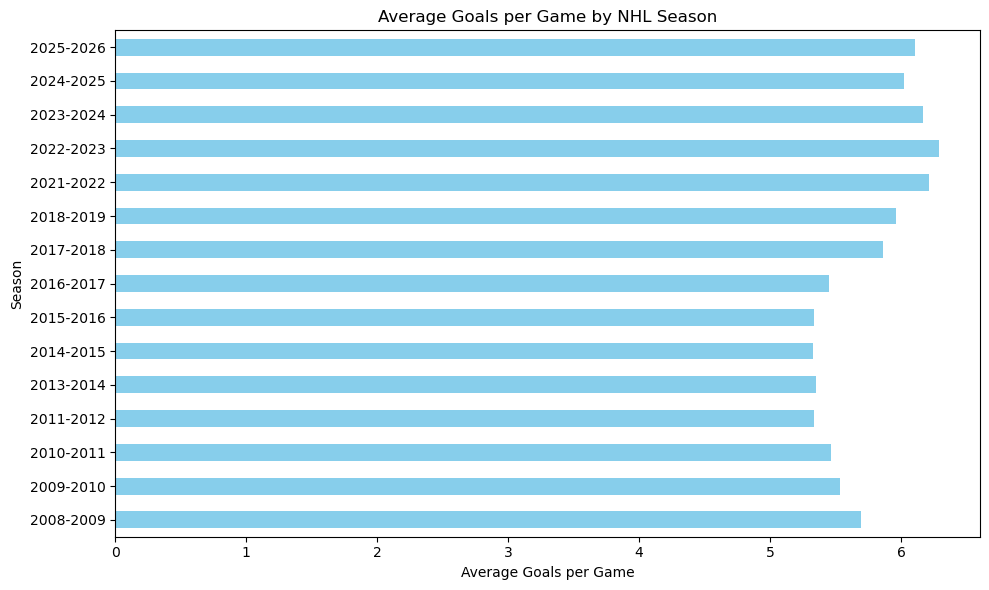

In [10]:
plt.figure(figsize=(10, 6))
goals_per_game_by_season.plot(kind='barh', color='skyblue')
plt.xlabel('Average Goals per Game')
plt.ylabel('Season')
plt.title('Average Goals per Game by NHL Season')
plt.tight_layout()
plt.show()

Scoring looks like it is trending up overall over time.

## Explore scoring by month

In [11]:
goals_per_game_by_month = games_df.groupby("month")["totalGoals"].mean()
print(goals_per_game_by_month)

month
1     5.690011
2     5.729902
3     5.738896
4     5.898944
10    5.810021
11    5.649734
12    5.705943
Name: totalGoals, dtype: float64


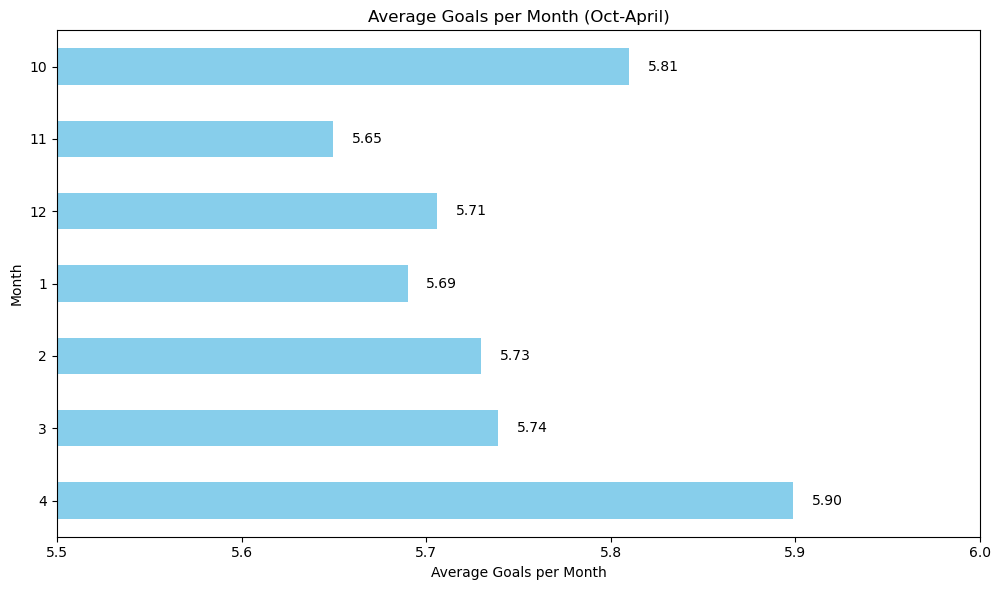

In [12]:
month_order = [10, 11, 12, 1, 2, 3, 4]
ordered_goals_per_game_by_month = goals_per_game_by_month.loc[month_order]

plt.figure(figsize=(10, 6))
ax = ordered_goals_per_game_by_month.plot(kind='barh', color='skyblue')
plt.xlabel('Average Goals per Month')
plt.ylabel('Month')
plt.title('Average Goals per Month (Oct-April)')
plt.tight_layout()
plt.gca().invert_yaxis()  # Reverse y-axis so 10 is at the top
plt.xlim(5.5, 6.0)

# Add value labels to bars
for i, v in enumerate(ordered_goals_per_game_by_month):
    ax.text(v + 0.01, i, f"{v:.2f}", va='center', color='black', fontsize=10)

plt.show()

Looks like the highest scoring month is actually April and not October!

In [13]:
avg_scoring_by_season_month = games_df.groupby(["season","month"])["totalGoals"].mean()

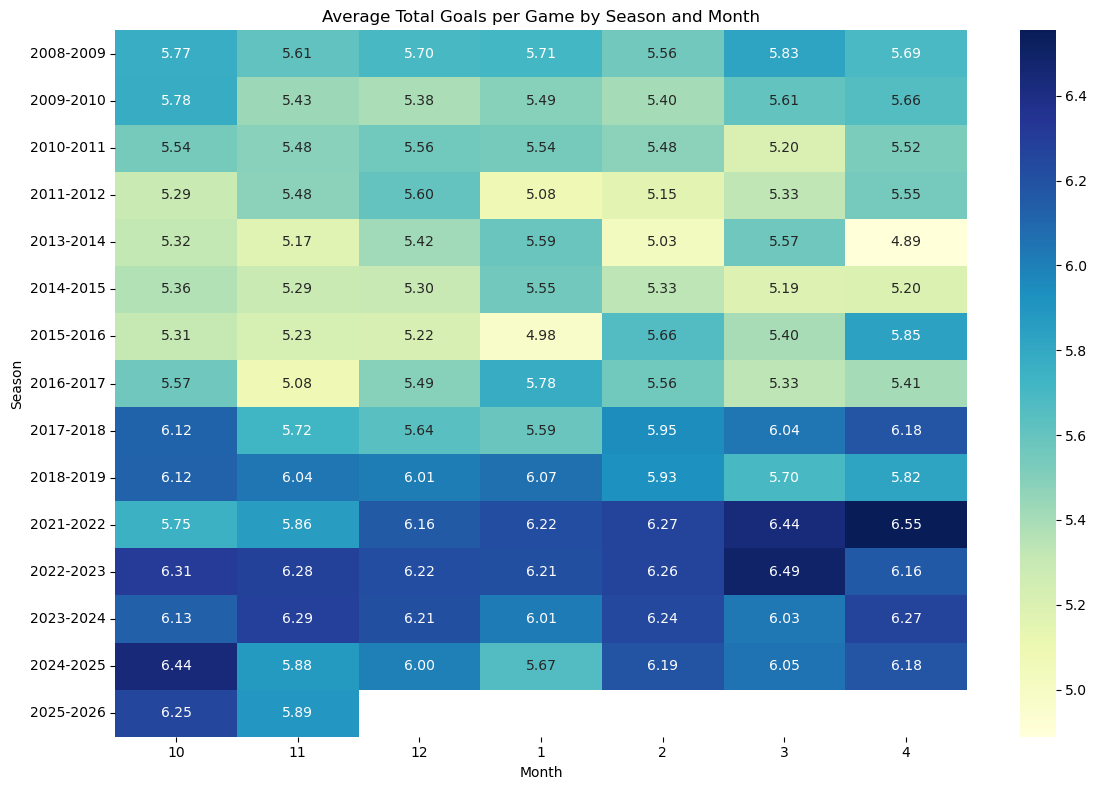

In [18]:
import seaborn as sns

# Pivot the grouped data for heatmap
month_order = [10, 11, 12, 1, 2, 3, 4]
heatmap_data = avg_scoring_by_season_month.unstack("month")
heatmap_data = heatmap_data[month_order]  # Reorder columns

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Total Goals per Game by Season and Month")
plt.xlabel("Month")
plt.ylabel("Season")
plt.tight_layout()
plt.show()

This is a fascinating visual. Scoring is clearly up the last handfull of season and it seems to be higher at the start and end of the season. 

## Differential of given month vs rest of the season

In [15]:
def calc_diff_score_for_month(month):
    month_games = games_df[games_df['month'] == month]
    month_games_avg_goals = month_games['totalGoals'].mean()
    all_other_months = games_df[games_df['month'] != 10]
    all_other_months_avg_goals = all_other_months['totalGoals'].mean()
    scoring_diff = month_games_avg_goals - all_other_months_avg_goals
    print(f"Scoring diff {month}: {scoring_diff:.2f} goals")
    return scoring_diff

months = [10, 11, 12, 1, 2, 3, 4]

for month in months:
    calc_diff_score_for_month(month)


Scoring diff 10: 0.09 goals
Scoring diff 11: -0.07 goals
Scoring diff 12: -0.01 goals
Scoring diff 1: -0.03 goals
Scoring diff 2: 0.01 goals
Scoring diff 3: 0.02 goals
Scoring diff 4: 0.18 goals


## Data Summary

The data we are looking at is games data from NHL regular season games from the 2008-2009 season trough the first two months of the 2025-2026 season. I have cleaned out the lockout and COVID shortened seasons because we are interested in how goal scoring progresses over the course of a season in a typical and those season schedule were irregular.

## EDA Summary

Based off of initial exploratory analysis it would appear that the logic that scoring is up the fist month of the season is not in fact true. Looking at historical data from 2008 to 2025, excluding lockout and COVID shortened seasons, the highest scoring per game average by month seems to be April (the last month of the season) and not October (the first month of the season).